In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, time
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold,cross_validate,train_test_split
from sklearn.metrics import confusion_matrix,f1_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

path_raw_data = "/anaconda3/envs/myenv"


Bad key "text.kerning_factor" on line 4 in
/anaconda3/envs/myenv/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## 1. loading data

In [2]:
data = pd.read_csv(os.path.join(path_raw_data,"train.csv"),sep = ',')

In [3]:
data.head(5)

,acidity,citric_acid,sugar,total_sulfur_dioxide,alcohol,pH,free_sulfur_dioxide,quality
0,83.721721,0.262484,21.137710,8558.587840,Low,3.61,168.77,0
1,82.005119,0.316941,21.281502,9424.589150,High,3.41,155.19,0
2,84.751683,0.320831,20.850128,9291.358179,Low,3.31,157.03,0
3,83.893382,0.353895,21.137710,10223.974974,Low,3.36,143.17,0
4,84.408362,0.281933,20.850128,11423.053711,Low,3.08,123.83,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acidity               1175 non-null   float64
 1   citric_acid           1175 non-null   float64
 2   sugar                 1177 non-null   float64
 3   total_sulfur_dioxide  1200 non-null   float64
 4   alcohol               1173 non-null   object 
 5   pH                    1200 non-null   float64
 6   free_sulfur_dioxide   1200 non-null   float64
 7   quality               1200 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 75.1+ KB


## 2. EDA

In [5]:
data.describe()

,acidity,citric_acid,sugar,total_sulfur_dioxide,pH,free_sulfur_dioxide,quality
count,1175.000000,1175.000000,1177.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,85.382662,0.314076,21.892523,9344.359125,17.418375,156.390042,0.134167
std,2.961525,0.037978,2.049290,1093.218952,117.717194,17.040968,0.340973
min,79.258555,0.262484,19.556006,7992.356215,2.740000,22.750000,0.000000
25%,83.378401,0.279988,20.993919,8525.280098,3.210000,148.622500,0.000000
50%,84.751683,0.311107,21.425293,9058.203980,3.310000,161.010000,0.000000
75%,86.811606,0.344170,22.000458,9857.589805,3.402500,168.995000,0.000000
max,98.484504,0.456975,40.549539,17418.447393,999.000000,176.990000,1.000000


### 2.1 missing values

In [6]:
#1.drop NaN
dim1 = data.shape[0]
data = data.dropna()
print('drop %d rows' %(dim1-data.shape[0]))

#2.delete anomaly 
data=data[data.pH!=999]
print('delete %d rows' %len(data.pH==999))
print('left %d rows' %len(data.pH!=999))

drop 98 rows
delete 1088 rows
left 1088 rows


### 2.2 categorical variables 

0    942
1    146
Name: quality, dtype: int64


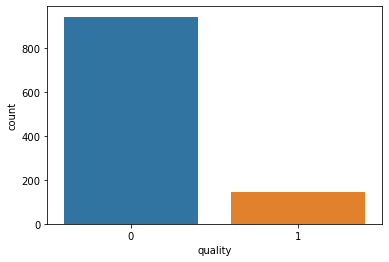

In [7]:
sns.countplot(data.quality)
print(data.quality.value_counts())

Low        585
Medium     360
High       108
lowW        20
unknown     15
Name: alcohol, dtype: int64


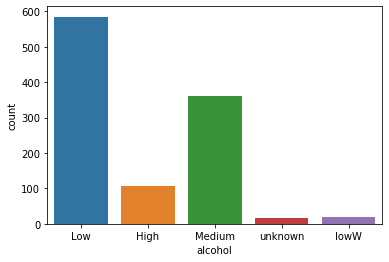

In [8]:
sns.countplot(data.alcohol)
print(data.alcohol.value_counts())

In [9]:
data = data[data.alcohol!='unknown']
print('remain %d rows' %data.shape[0])

remain 1073 rows


### 2.3 continuous variables

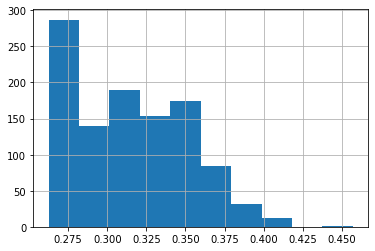

In [10]:
data.citric_acid.hist()

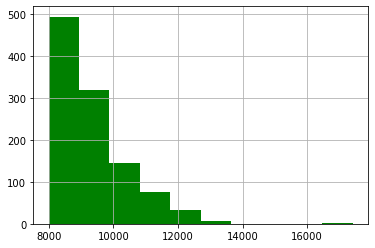

In [11]:
data.total_sulfur_dioxide.hist(color='g')

### 2.4 objective variable

Text(0.5, 1.0, 'boxplots grouped by quality')

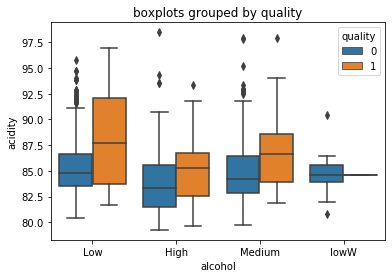

In [12]:
fig, axes = plt.subplots()
sns.boxplot(x = 'alcohol', y = 'acidity', hue ='quality',data = data, orient = 'v', ax=axes)
axes.set_title('boxplots grouped by quality')

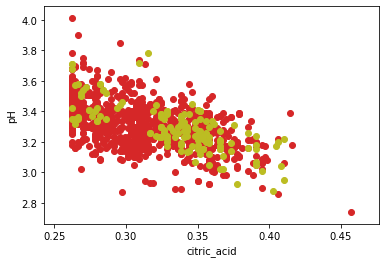

In [13]:
d1 = data.quality[data.quality==0]
d2 = data.quality[data.quality==1]
d1['citric_acid'] = data.citric_acid[data.quality==0]
d1['pH'] = data.pH[data.quality==0]
d2 = pd.DataFrame(columns=['citric_acid', 'pH'])
d2['citric_acid'] = data.citric_acid[data.quality==1]
d2['pH'] = data.pH[data.quality==1]

plt.scatter(d1['citric_acid'], d1['pH'], color='#d62728')
plt.scatter(d2['citric_acid'], d2['pH'], color='#bcbd22')

#plt.scatter('citric_acid','pH','quality', data=data,c=y, marker='o', alpha=1,cmap='coolwarm')
plt.xlabel('citric_acid')
plt.ylabel('pH')
plt.show()

In [14]:
data_q = data.groupby("quality").mean()
data_q

,acidity,citric_acid,sugar,total_sulfur_dioxide,pH,free_sulfur_dioxide
quality,,,,,,
0,85.210370,0.31054,21.823860,9400.856934,3.316203,155.523506
1,86.222553,0.33366,22.288041,8930.448255,3.296096,162.752877


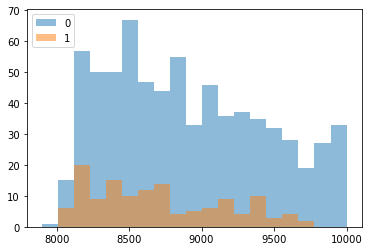

In [15]:
a = data.total_sulfur_dioxide[data.quality==0]
b = data.total_sulfur_dioxide[data.quality==1]

#bins = np.linspace(75, 100, 20)
#bins = np.linspace(0.30, 0.46, 20)
#bins = np.linspace(19, 40, 20)
bins = np.linspace(7900, 10000, 20)

plt.hist(a, bins, alpha = 0.5, label='0')
plt.hist(b, bins, alpha = 0.5, label='1')
plt.legend(loc='upper left')

plt.show()

## 3. correlation analysis (with Label encoding)

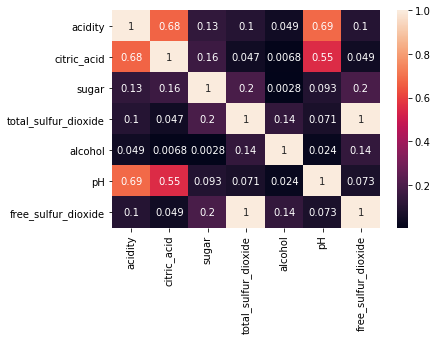

In [16]:
from sklearn.preprocessing import LabelEncoder
y = data['quality']
data2 = data.drop(['quality'],axis=1)
enc = LabelEncoder()
data2['alcohol']= enc.fit_transform(data2['alcohol'])
sns.heatmap(data2.corr().abs(),annot=True)
plt.show()

## 4. xgboost

In [17]:
SEED = 0
NFOLDS = 10
Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(preprocessing.scale(data2), y, )
te_index ={}
y_te = {}
pred_pro = {}
meta_y = np.zeros((len(x_test),NFOLDS))
tStart = time.time()
i = 0
for train_index, test_index in Kf.split(x_train,y_train):
    te_index[i] = test_index
    x_tr = x_train.iloc[train_index]
    y_tr = y_train.iloc[train_index]
    x_te = x_train.iloc[test_index]
    y_te[i] = y_train.iloc[test_index]
    clf_cv = xgb.XGBClassifier(n_jobs=-1)
    clf_cv.fit(x_tr, y_tr)
    pred_pro[i] = clf_cv.predict_proba(x_te)[:,1]
    meta_y[:,i] = clf_cv.predict_proba(x_test)[:,1]
    print('fold complete:',i+1)
    print('target ratio:',y_tr.mean())
    i = i+1

tEnd = time.time()
print('Time CV (s):',tEnd-tStart)

fold complete: 1
target ratio: 0.13692946058091288
fold complete: 2
target ratio: 0.13692946058091288
fold complete: 3
target ratio: 0.13692946058091288
fold complete: 4
target ratio: 0.13692946058091288
fold complete: 5
target ratio: 0.13674033149171272
fold complete: 6
target ratio: 0.13674033149171272
fold complete: 7
target ratio: 0.13674033149171272
fold complete: 8
target ratio: 0.13674033149171272
fold complete: 9
target ratio: 0.13674033149171272
fold complete: 10
target ratio: 0.13674033149171272
Time CV (s): 0.8615269660949707


In [18]:
threshold = np.arange(0.1,0.95,0.05)
f1_df_xgb = pd.DataFrame()
w = 0
for thres in threshold:
    for i in range(NFOLDS):
        f1_df_xgb.loc[w,'threshold'] = thres
        f1_df_xgb.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
        w = w + 1

f1_mean_xgb = f1_df_xgb.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

f1_std_xgb = f1_df_xgb.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)

In [19]:
print('threshold:',f1_mean_xgb['threshold'].values)
print('mean:',f1_mean_xgb['f1_score'].values)
print('std:',f1_std_xgb.loc[f1_mean_xgb.index,'f1_score'].values)

threshold: [0.1]
mean: [0.52010021]
std: [0.08911583]


In [20]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
pred_pro4sub = clf.predict_proba(x_test)[:,1]

Text(0.5, 0, 'Relative Importance')

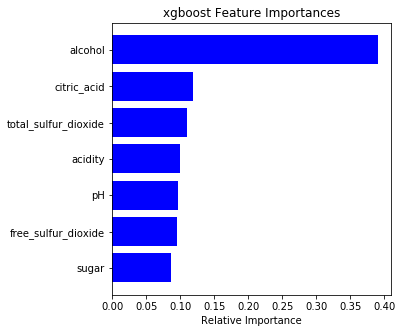

In [27]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = x_train.columns

plt.figure(figsize=(5,5)) 
plt.title('xgboost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')